# ViT 16

In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
import shutil
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###EDA

In [ ]:
DATASET_EDA_DIR = "/content/drive/MyDrive/dataset_TA/OCTeyes"

class_names = sorted([
    d for d in os.listdir(DATASET_EDA_DIR)
    if os.path.isdir(os.path.join(DATASET_EDA_DIR, d))
])

data_summary = []

for cls in class_names:
    cls_path = os.path.join(DATASET_EDA_DIR, cls)
    num_images = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    data_summary.append({
        "Class": cls,
        "Number of Images": num_images
    })



df = pd.DataFrame(data_summary)
df


Class  Number of Images
0     CNV              6000
1     DME              6000
2  DRUSEN              6000
3  NORMAL              6000

In [ ]:
total_images = df["Number of Images"].sum()

print("Total images:", total_images)
print("Number of classes:", len(class_names))
print("Average images per class:", total_images // len(class_names))


Total images: 24000
Number of classes: 4
Average images per class: 6000


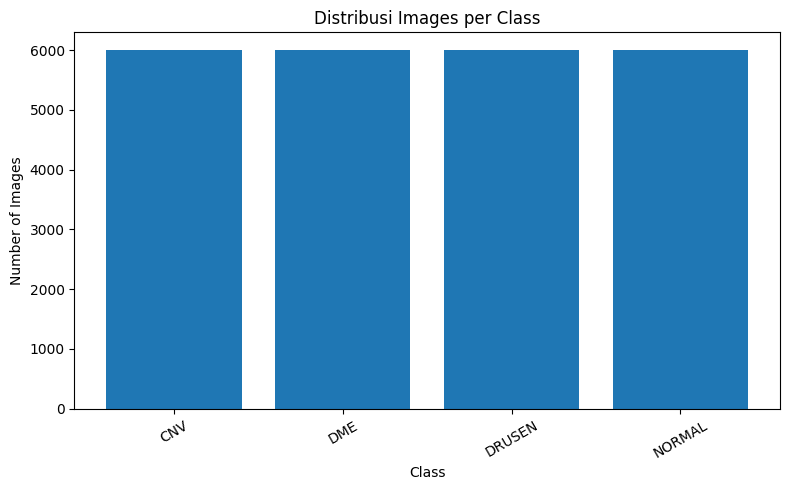

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df["Class"], df["Number of Images"])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribusi Images per Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


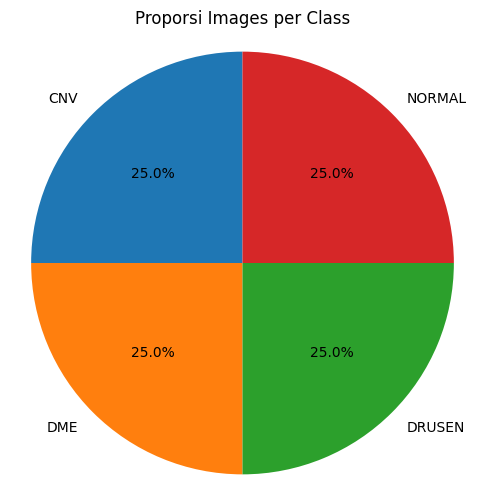

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(
    df["Number of Images"],
    labels=df["Class"],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Proporsi Images per Class")
plt.axis('equal')
plt.show()


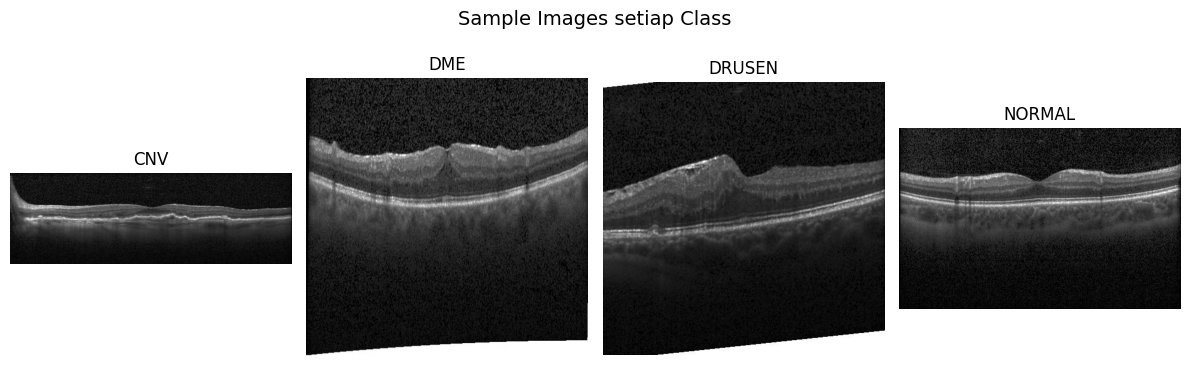

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12,4))

for i, cls in enumerate(class_names):
    cls_path = os.path.join(DATASET_EDA_DIR, cls)
    img_files = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    img_name = random.choice(img_files)
    img_path = os.path.join(cls_path, img_name)
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Sample Images setiap Class", fontsize=14)
plt.tight_layout()
plt.show()


##Versi DATA split 8:1:1

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMG_SIZE = 224

In [ ]:
RAW_DIR = Path("/content/drive/MyDrive/dataset_TA/OCTeyes")  # folder asli
SPLIT_DIR = Path("/content/dataset_split") # output split
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

class_names = sorted([d.name for d in RAW_DIR.iterdir() if d.is_dir()])
print("Classes:", class_names)


MAX_PER_CLASS = 6000

# rasio 8:1:1
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.8, 0.1, 0.1

def list_images(class_dir):
    files = [p for p in class_dir.rglob("*")
             if p.is_file() and p.suffix.lower() in IMG_EXTS]
    return files

def prepare_dirs():
    for split in ["train","val","test"]:
        for c in class_names:
            (SPLIT_DIR/split/c).mkdir(parents=True, exist_ok=True)

prepare_dirs()

for c in class_names:
    files = list_images(RAW_DIR/c)
    random.shuffle(files)

    if MAX_PER_CLASS is not None:
        files = files[:MAX_PER_CLASS]

    n = len(files)
    n_train = int(TRAIN_RATIO * n)
    n_val   = int(VAL_RATIO * n)


    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    def copy_files(file_list, split_name):
        for p in file_list:
            dst = SPLIT_DIR/split_name/c/p.name
            shutil.copy2(p, dst)

    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print(c, "-> Train:", len(train_files),' |val:', len(val_files)," |Test:", len(test_files))

print("Done split Ke:", SPLIT_DIR)

Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
CNV -> Train: 4800  |val: 600  |Test: 600
DME -> Train: 4800  |val: 600  |Test: 600
DRUSEN -> Train: 4800  |val: 600  |Test: 600
NORMAL -> Train: 4800  |val: 600  |Test: 600
Done split Ke: /content/dataset_split


###data preprocessing

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.10),
], name="augment")



In [ ]:
def load_ds(path, training=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=training
    )

    class_names = ds.class_names

    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=AUTOTUNE)


    if training:
        ds = ds.map(lambda x,y: (data_augment(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    if not training:
        ds = ds.cache()

    ds = ds.prefetch(AUTOTUNE)
    return ds, class_names


In [ ]:
train_ds, class_names = load_ds(SPLIT_DIR/"train", training=True)
val_ds, _ = load_ds(SPLIT_DIR/"val", training=False)
test_ds, _ = load_ds(SPLIT_DIR/"test", training=False)

print("class_names:", class_names)


Found 19200 files belonging to 4 classes.
Found 2400 files belonging to 4 classes.
Found 2400 files belonging to 4 classes.
class_names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


train min/max: 0.0 1.0740285


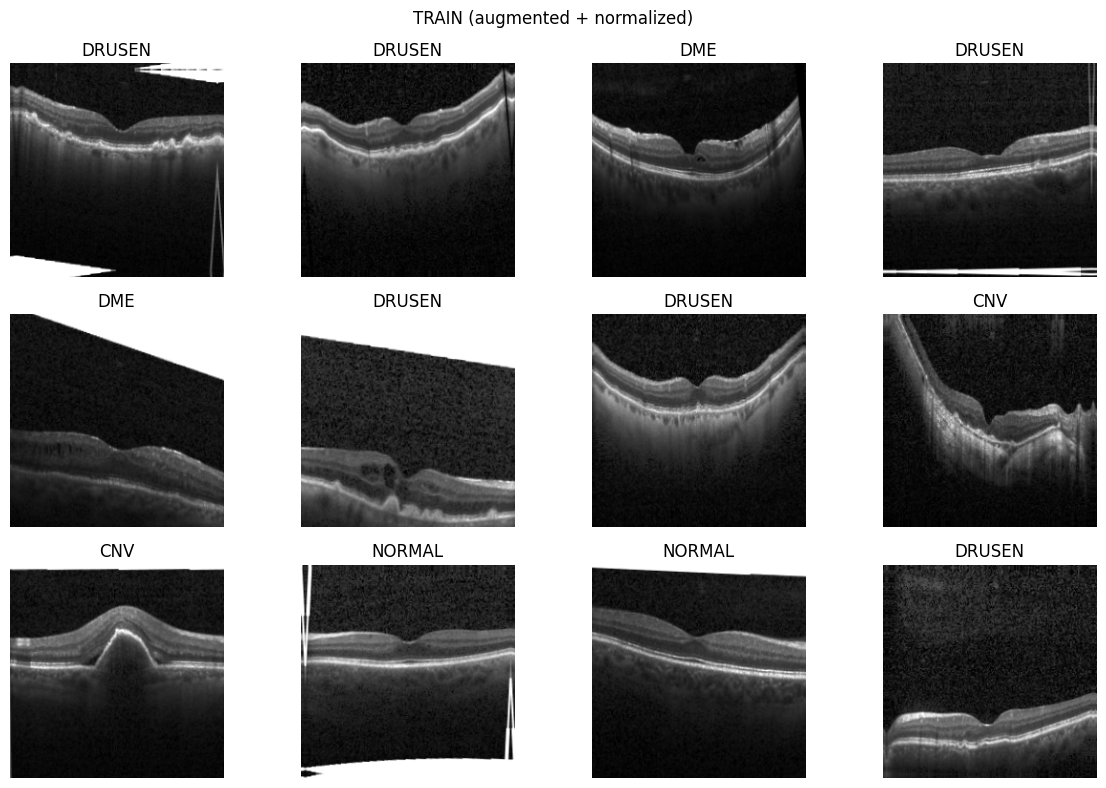

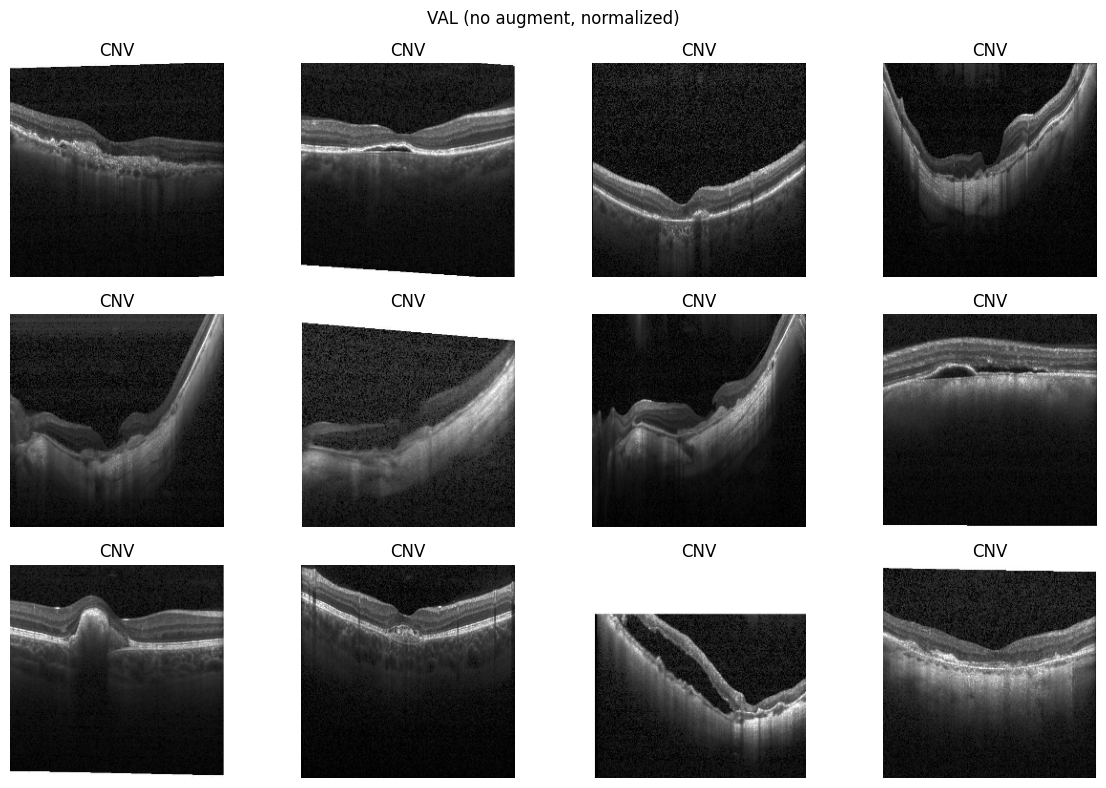

In [ ]:
for x,y in train_ds.take(1):
    print("train min/max:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())

import matplotlib.pyplot as plt
def show_batch(ds, title):
    plt.figure(figsize=(12,8))
    for x,y in ds.take(1):
        for i in range(12):
            plt.subplot(3,4,i+1)
            plt.imshow(x[i].numpy())
            plt.title(class_names[int(y[i])])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, "TRAIN (augmented + normalized)")
show_batch(val_ds, "VAL (no augment, normalized)")


### BUAT MODEL ViT-Small dari 0

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.proj = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)

def build_vit_small(
    input_shape=(224,224,3),
    num_classes=4,
    patch_size=16,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    dropout=0.1
):
    inputs = keras.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) ** 2

    x = PatchEncoder(num_patches, embed_dim)(patches)
    x = layers.Dropout(dropout)(x)

    for _ in range(depth):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout
        )(x1, x1)
        x2 = layers.Add()([x, attn])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(embed_dim*mlp_ratio, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x3 = layers.Dense(embed_dim)(x3)
        x = layers.Add()([x2, x3])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="vit_small")


In [ ]:
model = build_vit_small(num_classes=len(class_names))
model.summary()

Model: "vit_small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, None, 384) │    370,560 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 384) │          0 │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 384) │        768 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 384) │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 384) │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │    591,360 │ layer_normalizat… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None,      │          0 │ dense_1[0][0]     │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 384) │    590,208 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 384) │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 384) │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 384) │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │    591,360 │ layer_normalizat… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None,      │          0 │ dense_3[0][0]   

 Total params: 21,666,436 (82.65 MB)

 Trainable params: 21,666,436 (82.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import io

# Tangkap summary sebagai string
summary_string = io.StringIO()
model.summary(print_fn=lambda x: summary_string.write(x + '\n'))
summary_content = summary_string.getvalue()
summary_string.close()

# Simpan ke file
with open('model_summary_vit_small_2000.txt', 'w') as f:
    f.write(summary_content)

In [ ]:
import tensorflow as tf
from tensorflow import keras

NUM_CLASSES = len(class_names)

def to_one_hot(images, labels):
    return images, tf.one_hot(labels, NUM_CLASSES)

train_ds_oh = train_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_oh   = val_ds.map(to_one_hot,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_oh  = test_ds.map(to_one_hot,  num_parallel_calls=tf.data.AUTOTUNE)  # untuk evaluasi nanti

train_ds_oh = train_ds_oh.prefetch(tf.data.AUTOTUNE)
val_ds_oh   = val_ds_oh.prefetch(tf.data.AUTOTUNE)
test_ds_oh  = test_ds_oh.prefetch(tf.data.AUTOTUNE)


In [ ]:
for x, y in train_ds_oh.take(1):
    print("images:", x.shape)        # (batch, 224, 224, 3)
    print("labels:", y.shape)        # (batch, NUM_CLASSES)
    print("example label:", y[0].numpy())
    print("sum label:", tf.reduce_sum(y[0]).numpy())  # harus 1.0


images: (64, 224, 224, 3)
labels: (64, 4)
example label: [0. 0. 0. 1.]
sum label: 1.0


In [ ]:
EPOCHS = 50

steps_per_epoch = tf.data.experimental.cardinality(train_ds_oh).numpy()
if steps_per_epoch == tf.data.experimental.INFINITE_CARDINALITY:
    raise ValueError("Dataset cardinality infinite. Pastikan train_ds tidak di-repeat tanpa batas.")
if steps_per_epoch == tf.data.experimental.UNKNOWN_CARDINALITY:
    raise ValueError("Dataset cardinality unknown. Coba hilangkan cache/transform yang bikin unknown, atau set steps_per_epoch manual.")

total_steps = steps_per_epoch * EPOCHS

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps,
    alpha=1e-2
)

optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)


In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [ ]:
class SaveAtEpochs(keras.callbacks.Callback):
    def __init__(self, save_epochs, save_dir="epoch_checkpoints_V811"):
        super().__init__()
        self.save_epochs = set(save_epochs)   # {20, 40, 50}
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        epoch_human = epoch + 1
        if epoch_human in self.save_epochs:
            path = os.path.join(
                self.save_dir,
                f"vit_16p_811_epoch_{epoch_human:02d}.keras"
            )
            self.model.save(path)
            print(f"\nSaved checkpoint di epoch {epoch_human} -> {path}")


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=40,
        restore_best_weights=False,
        verbose=1
    ),
    SaveAtEpochs(
        save_epochs=[20, 40, 50],
        save_dir="epoch_checkpoints_V811"
    )
]


In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 372s 973ms/step - accuracy: 0.2564 - loss: 1.7928 - val_accuracy: 0.2896 - val_loss: 1.4154
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 287s 951ms/step - accuracy: 0.2864 - loss: 1.4144 - val_accuracy: 0.3275 - val_loss: 1.3352
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 286s 951ms/step - accuracy: 0.3683 - loss: 1.3337 - val_accuracy: 0.4575 - val_loss: 1.2126
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 319s 940ms/step - accuracy: 0.4536 - loss: 1.2276 - val_accuracy: 0.5325 - val_loss: 1.1379
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.5362 - loss: 1.1273 - val_accuracy: 0.6037 - val_loss: 1.0238
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 280s 930ms/step - accuracy: 0.5919 - loss: 1.0467 - val_accuracy: 0.6413 - val_loss: 0.9752
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 285s 946ms/step - accuracy: 0.6382 - loss: 0.9824 - val_accuracy: 0.6354 - val_loss: 0.9756
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 320s 937ms/step - accuracy: 0.6707 - lo

In [ ]:
model.save("final_vit_model_16p_811.keras")


####evaluasi

In [ ]:
import numpy as np
import tensorflow as tf

def collect_preds(ds, model):
    y_true_list = []
    y_prob_list = []

    for x_batch, y_batch in ds:
        probs = model.predict(x_batch, verbose=0)
        y_prob_list.append(probs)

        yb = y_batch.numpy()

        if len(yb.shape) == 2:
            y_true_list.append(np.argmax(yb, axis=1))
        else:
            y_true_list.append(yb)

    y_true = np.concatenate(y_true_list, axis=0)
    y_prob = np.concatenate(y_prob_list, axis=0)
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob

In [ ]:
ds_for_eval = test_ds

In [ ]:
y_true, y_pred, y_prob = collect_preds(ds_for_eval, model)
num_classes = len(class_names)

print("Total test samples:", len(y_true))
print("Num classes:", num_classes)


Total test samples: 2400
Num classes: 4


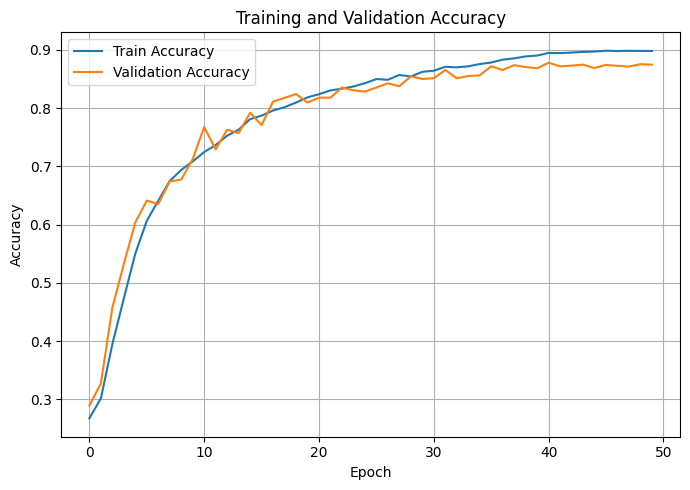

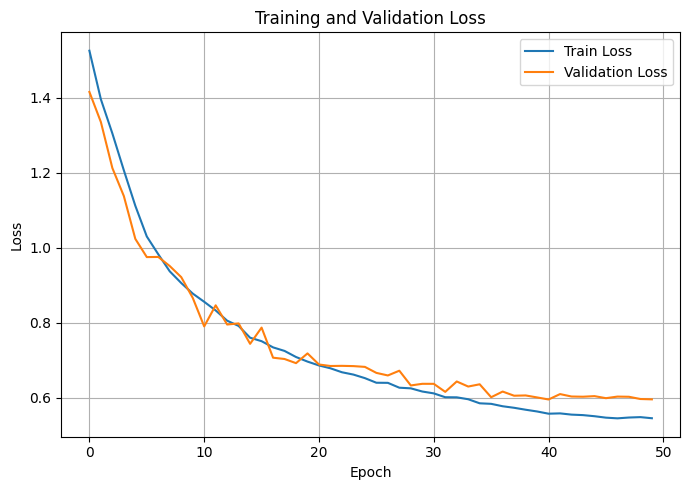

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(7,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


confusion matrix

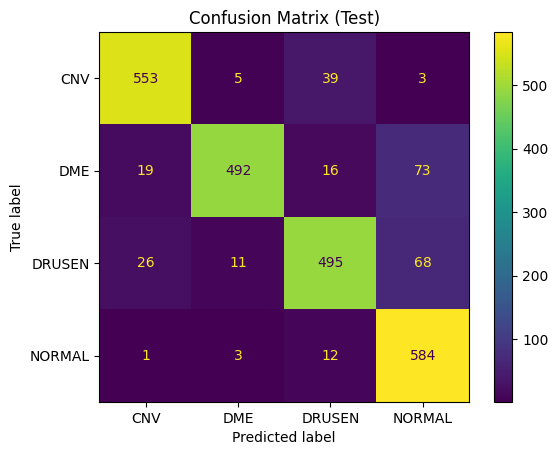


Classification Report:
              precision    recall  f1-score   support

         CNV     0.9232    0.9217    0.9224       600
         DME     0.9628    0.8200    0.8857       600
      DRUSEN     0.8808    0.8250    0.8520       600
      NORMAL     0.8022    0.9733    0.8795       600

    accuracy                         0.8850      2400
   macro avg     0.8923    0.8850    0.8849      2400
weighted avg     0.8923    0.8850    0.8849      2400



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


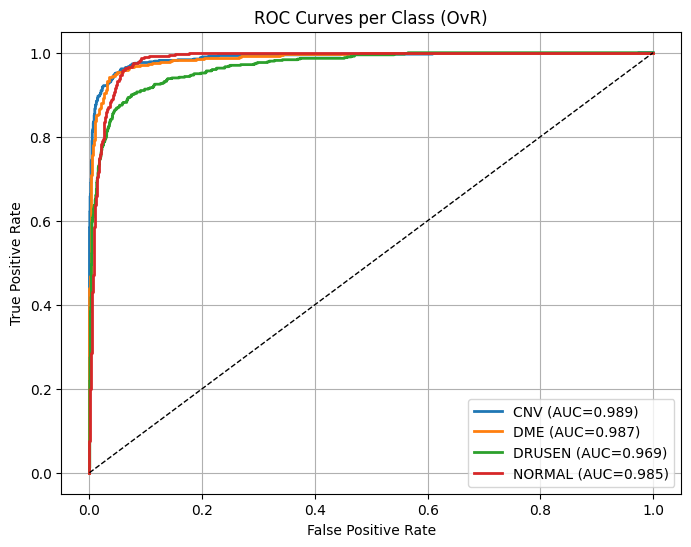


ROC–AUC per kelas:
- CNV: 0.9885
- DME: 0.9874
- DRUSEN: 0.9686
- NORMAL: 0.9846
Macro ROC–AUC: 0.9822710648148149


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nROC–AUC per kelas:")
for i in range(num_classes):
    print(f"- {class_names[i]}: {roc_auc[i]:.4f}")
print("Macro ROC–AUC:", float(np.mean(list(roc_auc.values()))))


##### Sensitiviy & specificity

In [ ]:
def sensitivity_specificity(cm, class_names):
    results = []
    total = cm.sum()
    num_classes = cm.shape[0]

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        results.append({
            "class": class_names[i],
            "Sensitivity": sensitivity,
            "Specificity": specificity
        })

    return results


In [ ]:
results = sensitivity_specificity(cm, class_names)

print("\nSensitivity & Specificity per kelas:")
for r in results:
    print(
        f"- {r['class']:10s} | "
        f"Sensitivity: {r['Sensitivity']:.4f} | "
        f"Specificity: {r['Specificity']:.4f}"
    )

# Macro average
macro_sens = np.mean([r["Sensitivity"] for r in results])
macro_spec = np.mean([r["Specificity"] for r in results])

print("\nMacro Average:")
print(f"Sensitivity (macro): {macro_sens:.4f}")
print(f"Specificity (macro): {macro_spec:.4f}")


Sensitivity & Specificity per kelas:
- CNV        | Sensitivity: 0.9217 | Specificity: 0.9744
- DME        | Sensitivity: 0.8200 | Specificity: 0.9894
- DRUSEN     | Sensitivity: 0.8250 | Specificity: 0.9628
- NORMAL     | Sensitivity: 0.9733 | Specificity: 0.9200

Macro Average:
Sensitivity (macro): 0.8850
Specificity (macro): 0.9617


#####inferensi

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.proj = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim": self.embed_dim
        })
        return config


In [ ]:
modelload = keras.models.load_model(
    "/content/drive/MyDrive/modelvitTA/vit_tiny_16p_811_epoch_40.keras",
    custom_objects={
        "Patches": Patches,
        "PatchEncoder": PatchEncoder
    },
    compile=False
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
import os

SPLIT_DIR = "/content/dataset_split"  # ganti sesuai path split kamu
class_names = sorted(os.listdir(f"{SPLIT_DIR}/train"))
print("class_names:", class_names)


class_names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [ ]:
y_true, y_pred, y_prob = collect_preds(ds_for_eval, modelload)
num_classes = len(class_names)

print("Total test samples:", len(y_true))
print("Num classes:", num_classes)

Total test samples: 2400
Num classes: 4


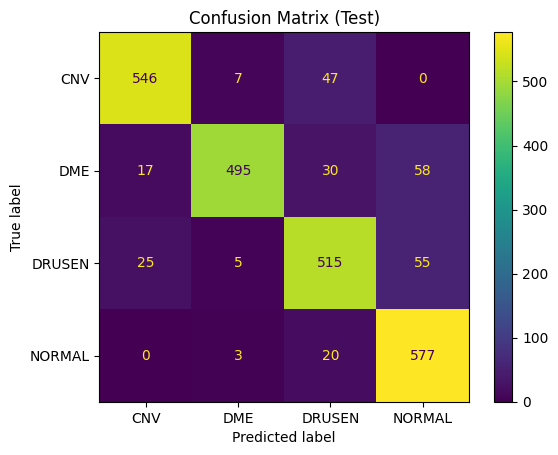


Classification Report:
              precision    recall  f1-score   support

         CNV     0.9286    0.9100    0.9192       600
         DME     0.9706    0.8250    0.8919       600
      DRUSEN     0.8415    0.8583    0.8498       600
      NORMAL     0.8362    0.9617    0.8946       600

    accuracy                         0.8888      2400
   macro avg     0.8942    0.8887    0.8889      2400
weighted avg     0.8942    0.8888    0.8889      2400



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [ ]:
import numpy as np
from PIL import Image

IMG_SIZE = 224

def predict_image(model, img_path, class_names, img_size=224):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((img_size, img_size))
    x = np.array(img).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)  # (1,224,224,3)

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]

    return pred_label, probs


In [ ]:
img_path = "/content/dataset_split/test/CNV/CNV-9206635-74.jpeg"  # ganti ke dir gambar OCT yang mau di pilih
label, probs = predict_image(modelload, img_path, class_names)

print("Predicted:", label)
print("Probabilities:")
for c, p in zip(class_names, probs):
    print(f"  {c:8s}: {p:.4f}")


Predicted: CNV
Probabilities:
  CNV     : 0.9297
  DME     : 0.0232
  DRUSEN  : 0.0217
  NORMAL  : 0.0254


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = 224

# =========================
# Mapping rekomendasi terapi
# =========================
THERAPY_RECOMMENDATION = {
    "cnv": [
        "Injeksi intravitreal anti-VEGF sebagai terapi utama pada CNV aktif, terutama pada CNV terkait AMD neovaskular maupun CNV miopia.",
        "Monitoring respon terapi secara berkala melalui pemeriksaan klinis dan pencitraan, karena CNV sering memerlukan terapi berulang atau penyesuaian protokol.",
        "Pemantauan efek samping terapi anti-VEGF diperlukan karena adanya potensi risiko okular tertentu."
    ],
    "dme": [
        "Anti-VEGF intravitreal merupakan terapi utama pada DME, khususnya untuk perbaikan fungsi penglihatan.",
        "Kortikosteroid intravitreal dapat dipertimbangkan pada DME persisten atau kurang respons terhadap anti-VEGF, dengan pemantauan risiko peningkatan tekanan intraokular dan katarak.",
        "Laser fotokoagulasi lebih sering berperan sebagai terapi adjuvan, bukan lini pertama.",
        "Vitrektomi dipertimbangkan pada kasus dengan indikasi bedah tertentu, seperti adanya komponen traksi vitreomakular.",
        "Kontrol faktor sistemik (glukosa darah, tekanan darah, dan lipid) merupakan bagian penting dari penatalaksanaan komprehensif."
    ],
    "drusen": [
        "Suplemen formula AREDS/AREDS2 direkomendasikan pada kondisi AMD tertentu, khususnya intermediate AMD atau drusen besar, untuk memperlambat progresi penyakit.",
        "Modifikasi gaya hidup dan pemantauan berkala diperlukan untuk mendeteksi progresi menuju AMD lanjut.",
        "Apabila berkembang menjadi AMD neovaskular dengan CNV, pendekatan terapi beralih ke anti-VEGF."
    ]
}


def predict_top1_with_therapy(model, img_path, class_names, img_size=224):
    # --- Preprocess ---
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((img_size, img_size))
    x = np.array(img_resized).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)

    # --- Predict ---
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    confidence = float(probs[pred_idx])

    # --- Tampilkan gambar ---
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label.upper()}\nConfidence: {confidence:.4f}")
    plt.show()

    # --- Rekomendasi terapi ---
    label_key = pred_label.lower()
    recommendations = THERAPY_RECOMMENDATION.get(label_key, [])

    print("=== HASIL INFERENSI MODEL ===")
    print(f"Kelas Prediksi : {pred_label.upper()}")
    print(f"Confidence     : {confidence:.4f}\n")

    print("=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    print("\nNote:")
    print("Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.")

    return pred_label, confidence



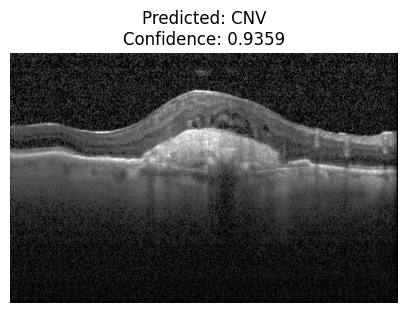

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : CNV
Confidence     : 0.9359

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Injeksi intravitreal anti-VEGF sebagai terapi utama pada CNV aktif, terutama pada CNV terkait AMD neovaskular maupun CNV miopia.
2. Monitoring respon terapi secara berkala melalui pemeriksaan klinis dan pencitraan, karena CNV sering memerlukan terapi berulang atau penyesuaian protokol.
3. Pemantauan efek samping terapi anti-VEGF diperlukan karena adanya potensi risiko okular tertentu.

Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


('CNV', 0.9358794093132019)

In [ ]:
img_path = "/content/dataset_split/test/CNV/CNV-9320911-157.jpeg"
predict_top1_with_therapy(modelload, img_path, class_names)

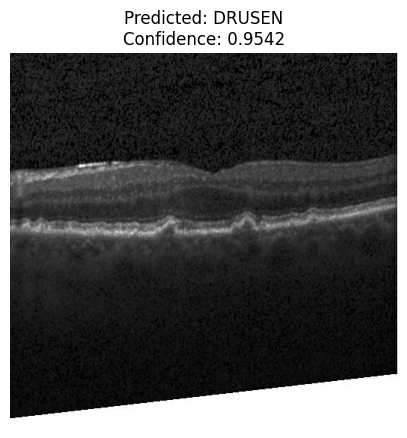

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : DRUSEN
Confidence     : 0.9542

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Suplemen formula AREDS/AREDS2 direkomendasikan pada kondisi AMD tertentu, khususnya intermediate AMD atau drusen besar, untuk memperlambat progresi penyakit.
2. Modifikasi gaya hidup dan pemantauan berkala diperlukan untuk mendeteksi progresi menuju AMD lanjut.
3. Apabila berkembang menjadi AMD neovaskular dengan CNV, pendekatan terapi beralih ke anti-VEGF.

Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


('DRUSEN', 0.9542328119277954)

In [ ]:
img_path = "/content/dataset_split/test/DRUSEN/DRUSEN-5801431-11.jpeg"
predict_top1_with_therapy(model, img_path, class_names)

Saving DRUSEN-8854406-4.jpeg to DRUSEN-8854406-4.jpeg


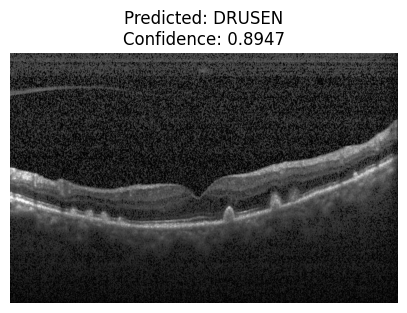

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : DRUSEN
Confidence     : 0.8947

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Suplemen formula AREDS/AREDS2 direkomendasikan pada kondisi AMD tertentu, khususnya intermediate AMD atau drusen besar, untuk memperlambat progresi penyakit.
2. Modifikasi gaya hidup dan pemantauan berkala diperlukan untuk mendeteksi progresi menuju AMD lanjut.
3. Apabila berkembang menjadi AMD neovaskular dengan CNV, pendekatan terapi beralih ke anti-VEGF.

Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


In [ ]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

pred_label, conf = predict_top1_with_therapy(model, img_path, class_names)



##Versi DATA split 7 : 1 : 2

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMG_SIZE = 224

RAW_DIR = Path("/content/drive/MyDrive/dataset_TA/OCTeyes")  # folder asli
SPLIT_DIR = Path("/content/dataset_split") # output split
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

class_names = sorted([d.name for d in RAW_DIR.iterdir() if d.is_dir()])
print("Classes:", class_names)

# (opsional) standarisasi max 6000/kelas
MAX_PER_CLASS = 6000

# rasio 7:1:2
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.1, 0.2

def list_images(class_dir):
    files = [p for p in class_dir.rglob("*")
             if p.is_file() and p.suffix.lower() in IMG_EXTS]
    return files

def prepare_dirs():
    for split in ["train","val","test"]:
        for c in class_names:
            (SPLIT_DIR/split/c).mkdir(parents=True, exist_ok=True)

prepare_dirs()

for c in class_names:
    files = list_images(RAW_DIR/c)
    random.shuffle(files)

    if MAX_PER_CLASS is not None:
        files = files[:MAX_PER_CLASS]

    n = len(files)
    n_train = int(TRAIN_RATIO * n)
    n_val   = int(VAL_RATIO * n)


    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    def copy_files(file_list, split_name):
        for p in file_list:
            dst = SPLIT_DIR/split_name/c/p.name
            shutil.copy2(p, dst)

    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print(c, "-> Train:", len(train_files),'|val:', len(val_files),"|Test:", len(test_files))

print("Done Data split Ke:", SPLIT_DIR)

Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
CNV -> Train: 4200 |val: 600 |Test: 1200
DME -> Train: 4200 |val: 600 |Test: 1200
DRUSEN -> Train: 4200 |val: 600 |Test: 1200
NORMAL -> Train: 4200 |val: 600 |Test: 1200
Done Data split Ke: /content/dataset_split


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.10),
], name="augment")

In [ ]:
def load_ds(path, training=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        image_size=(IMG_SIZE, IMG_SIZE),#resize
        batch_size=BATCH_SIZE,
        shuffle=training
    )

    class_names = ds.class_names  #  ambil DI SINI

    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y), #normalisasi
                num_parallel_calls=AUTOTUNE)

    #augment training
    if training:
        ds = ds.map(lambda x,y: (data_augment(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    if not training:
        ds = ds.cache()

    ds = ds.prefetch(AUTOTUNE)
    return ds, class_names


In [ ]:
train_ds, class_names = load_ds(SPLIT_DIR/"train", training=True)
val_ds, _ = load_ds(SPLIT_DIR/"val", training=False)
test_ds, _ = load_ds(SPLIT_DIR/"test", training=False)

print("class_names:", class_names)

Found 16800 files belonging to 4 classes.
Found 2400 files belonging to 4 classes.
Found 4800 files belonging to 4 classes.
class_names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.proj = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)

def build_vit_small(
    input_shape=(224,224,3),
    num_classes=4,
    patch_size=16,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    dropout=0.1
):
    inputs = keras.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) ** 2

    x = PatchEncoder(num_patches, embed_dim)(patches)
    x = layers.Dropout(dropout)(x)

    for _ in range(depth):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout
        )(x1, x1)
        x2 = layers.Add()([x, attn])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(embed_dim*mlp_ratio, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x3 = layers.Dense(embed_dim)(x3)
        x = layers.Add()([x2, x3])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="vit_small")


model = build_vit_small(num_classes=len(class_names))
model.summary()

Model: "vit_small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, None, 384) │    370,560 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 384) │          0 │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 384) │        768 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 384) │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 384) │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │    591,360 │ layer_normalizat… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None,      │          0 │ dense_1[0][0]     │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 384) │    590,208 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 384) │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 384) │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 384) │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │    591,360 │ layer_normalizat… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None,      │          0 │ dense_3[0][0]   

 Total params: 21,666,436 (82.65 MB)

 Trainable params: 21,666,436 (82.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
NUM_CLASSES = len(class_names)

def to_one_hot(images, labels):
    return images, tf.one_hot(labels, NUM_CLASSES)

train_ds_oh = train_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_oh   = val_ds.map(to_one_hot,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_oh  = test_ds.map(to_one_hot,  num_parallel_calls=tf.data.AUTOTUNE)  # untuk evaluasi nanti

train_ds_oh = train_ds_oh.prefetch(tf.data.AUTOTUNE)
val_ds_oh   = val_ds_oh.prefetch(tf.data.AUTOTUNE)
test_ds_oh  = test_ds_oh.prefetch(tf.data.AUTOTUNE)


In [ ]:
EPOCHS = 50

steps_per_epoch = tf.data.experimental.cardinality(train_ds_oh).numpy()
if steps_per_epoch == tf.data.experimental.INFINITE_CARDINALITY:
    raise ValueError("Dataset cardinality infinite. Pastikan train_ds tidak di-repeat tanpa batas.")
if steps_per_epoch == tf.data.experimental.UNKNOWN_CARDINALITY:
    raise ValueError("Dataset cardinality unknown. Coba hilangkan cache/transform yang bikin unknown, atau set steps_per_epoch manual.")

total_steps = steps_per_epoch * EPOCHS

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps,
    alpha=1e-2
)

optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [ ]:
class SaveAtEpochs(keras.callbacks.Callback):
    def __init__(self, save_epochs, save_dir="epoch_checkpoints_V712"):
        super().__init__()
        self.save_epochs = set(save_epochs)   # {20, 35, 50}
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        epoch_human = epoch + 1
        if epoch_human in self.save_epochs:
            path = os.path.join(
                self.save_dir,
                f"vit_epoch_{epoch_human:02d}.keras"
            )
            self.model.save(path)
            print(f"\n Saved checkpoint di epoch {epoch_human} -> {path}")


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=25,
        restore_best_weights=False,
        verbose=1
    ),
    SaveAtEpochs(
        save_epochs=[20, 35, 50],
        save_dir="epoch_checkpoints_V712"
    )
]

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.2537 - loss: 1.8741 - val_accuracy: 0.3067 - val_loss: 1.3896
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 245s 927ms/step - accuracy: 0.2660 - loss: 1.4286 - val_accuracy: 0.3279 - val_loss: 1.3614
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 244s 922ms/step - accuracy: 0.3175 - loss: 1.3807 - val_accuracy: 0.3967 - val_loss: 1.2927
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 259s 909ms/step - accuracy: 0.4003 - loss: 1.2981 - val_accuracy: 0.4758 - val_loss: 1.2156
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 264s 914ms/step - accuracy: 0.4561 - loss: 1.2375 - val_accuracy: 0.4421 - val_loss: 1.2310
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 242s 915ms/step - accuracy: 0.5015 - loss: 1.1762 - val_accuracy: 0.5729 - val_loss: 1.0754
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 245s 925ms/step - accuracy: 0.5685 - loss: 1.0850 - val_accuracy: 0.5350 - val_loss: 1.1259
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 240s 908ms/step - accuracy: 0.5965 - lo

In [ ]:
model.save("final_vit_model_16p_712.keras")

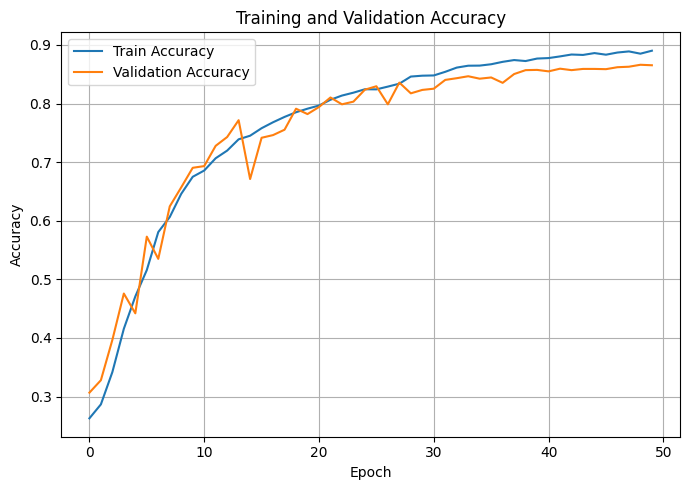

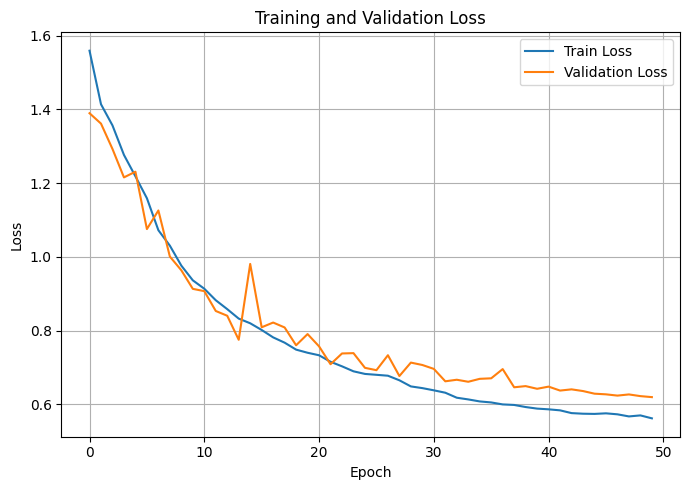

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(7,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf

def collect_preds(ds, model):
    y_true_list = []
    y_prob_list = []

    for x_batch, y_batch in ds:
        probs = model.predict(x_batch, verbose=0)
        y_prob_list.append(probs)

        yb = y_batch.numpy()
        # Jika y_batch one-hot -> ambil argmax, jika integer -> langsung
        if len(yb.shape) == 2:
            y_true_list.append(np.argmax(yb, axis=1))
        else:
            y_true_list.append(yb)

    y_true = np.concatenate(y_true_list, axis=0)
    y_prob = np.concatenate(y_prob_list, axis=0)
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob

ds_for_eval = test_ds
#ds_for_eval = test_ds_oh

y_true, y_pred, y_prob = collect_preds(ds_for_eval, model)
num_classes = len(class_names)

print("Total test samples:", len(y_true))
print("Num classes:", num_classes)


Total test samples: 4800
Num classes: 4


confusion matrix

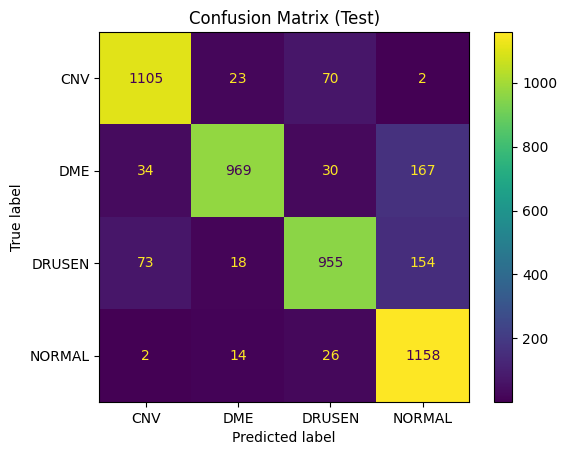


Classification Report:
              precision    recall  f1-score   support

         CNV     0.9102    0.9208    0.9155      1200
         DME     0.9463    0.8075    0.8714      1200
      DRUSEN     0.8834    0.7958    0.8374      1200
      NORMAL     0.7819    0.9650    0.8639      1200

    accuracy                         0.8723      4800
   macro avg     0.8805    0.8723    0.8720      4800
weighted avg     0.8805    0.8723    0.8720      4800



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Roc AUc

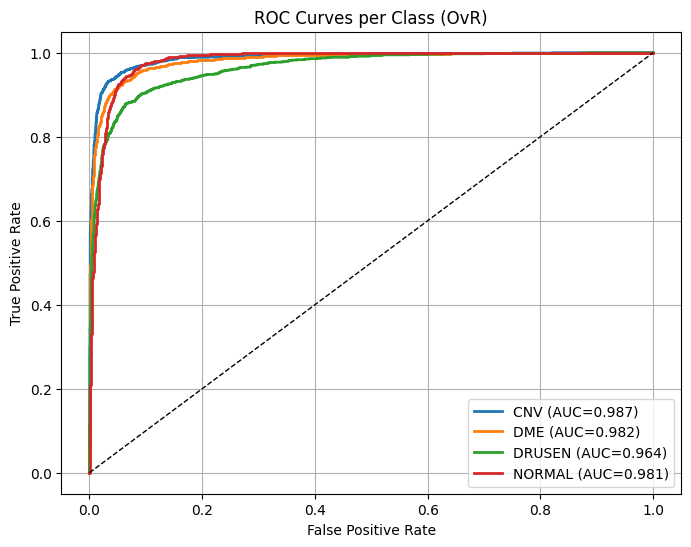


ROC–AUC per kelas:
- CNV: 0.9869
- DME: 0.9820
- DRUSEN: 0.9642
- NORMAL: 0.9810
Macro ROC–AUC: 0.9785178240740741


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nROC–AUC per kelas:")
for i in range(num_classes):
    print(f"- {class_names[i]}: {roc_auc[i]:.4f}")
print("Macro ROC–AUC:", float(np.mean(list(roc_auc.values()))))


In [ ]:
def sensitivity_specificity(cm, class_names):
    results = []
    total = cm.sum()
    num_classes = cm.shape[0]

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        results.append({
            "class": class_names[i],
            "Sensitivity": sensitivity,
            "Specificity": specificity
        })

    return results




In [ ]:
results = sensitivity_specificity(cm, class_names)

print("\nSensitivity & Specificity per kelas:")
for r in results:
    print(
        f"- {r['class']:10s} | "
        f"Sensitivity: {r['Sensitivity']:.4f} | "
        f"Specificity: {r['Specificity']:.4f}"
    )

# Macro average
macro_sens = np.mean([r["Sensitivity"] for r in results])
macro_spec = np.mean([r["Specificity"] for r in results])

print("\nMacro Average:")
print(f"Sensitivity (macro): {macro_sens:.4f}")
print(f"Specificity (macro): {macro_spec:.4f}")



Sensitivity & Specificity per kelas:
- CNV        | Sensitivity: 0.9208 | Specificity: 0.9697
- DME        | Sensitivity: 0.8075 | Specificity: 0.9847
- DRUSEN     | Sensitivity: 0.7958 | Specificity: 0.9650
- NORMAL     | Sensitivity: 0.9650 | Specificity: 0.9103

Macro Average:
Sensitivity (macro): 0.8723
Specificity (macro): 0.9574


inferensi

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.proj = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim": self.embed_dim
        })
        return config


In [ ]:
modelload = keras.models.load_model(
    "/content/final_vit_model_16p_712.keras",
    custom_objects={
        "Patches": Patches,
        "PatchEncoder": PatchEncoder
    },
    compile=False
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
import os

SPLIT_DIR = "/content/dataset_split"  # ganti sesuai path split kamu
class_names = sorted(os.listdir(f"{SPLIT_DIR}/train"))
print("class_names:", class_names)

class_names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [ ]:
import numpy as np
from PIL import Image

IMG_SIZE = 224

def predict_image(model, img_path, class_names, img_size=224):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((img_size, img_size))
    x = np.array(img).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)  # (1,224,224,3)

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]

    return pred_label, probs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = 224

# =========================
# Mapping rekomendasi terapi
# =========================
THERAPY_RECOMMENDATION = {
    "cnv": [
        "Injeksi intravitreal anti-VEGF sebagai terapi utama pada CNV aktif, terutama pada CNV terkait AMD neovaskular maupun CNV miopia.",
        "Monitoring respon terapi secara berkala melalui pemeriksaan klinis dan pencitraan, karena CNV sering memerlukan terapi berulang atau penyesuaian protokol.",
        "Pemantauan efek samping terapi anti-VEGF diperlukan karena adanya potensi risiko okular tertentu."
    ],
    "dme": [
        "Anti-VEGF intravitreal merupakan terapi utama pada DME, khususnya untuk perbaikan fungsi penglihatan.",
        "Kortikosteroid intravitreal dapat dipertimbangkan pada DME persisten atau kurang respons terhadap anti-VEGF, dengan pemantauan risiko peningkatan tekanan intraokular dan katarak.",
        "Laser fotokoagulasi lebih sering berperan sebagai terapi adjuvan, bukan lini pertama.",
        "Vitrektomi dipertimbangkan pada kasus dengan indikasi bedah tertentu, seperti adanya komponen traksi vitreomakular.",
        "Kontrol faktor sistemik (glukosa darah, tekanan darah, dan lipid) merupakan bagian penting dari penatalaksanaan komprehensif."
    ],
    "drusen": [
        "Suplemen formula AREDS/AREDS2 direkomendasikan pada kondisi AMD tertentu, khususnya intermediate AMD atau drusen besar, untuk memperlambat progresi penyakit.",
        "Modifikasi gaya hidup dan pemantauan berkala diperlukan untuk mendeteksi progresi menuju AMD lanjut.",
        "Apabila berkembang menjadi AMD neovaskular dengan CNV, pendekatan terapi beralih ke anti-VEGF."
    ]
}


def predict_top1_with_therapy(model, img_path, class_names, img_size=224):
    # --- Preprocess ---
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((img_size, img_size))
    x = np.array(img_resized).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)

    # --- Predict ---
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    confidence = float(probs[pred_idx])

    # --- Tampilkan gambar ---
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label.upper()}\nConfidence: {confidence:.4f}")
    plt.show()

    # --- Rekomendasi terapi ---
    label_key = pred_label.lower()
    recommendations = THERAPY_RECOMMENDATION.get(label_key, [])

    print("=== HASIL INFERENSI MODEL ===")
    print(f"Kelas Prediksi : {pred_label.upper()}")
    print(f"Confidence     : {confidence:.4f}\n")

    print("=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    print("\n⚠️ Note:")
    print("Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.")

    return pred_label, confidence



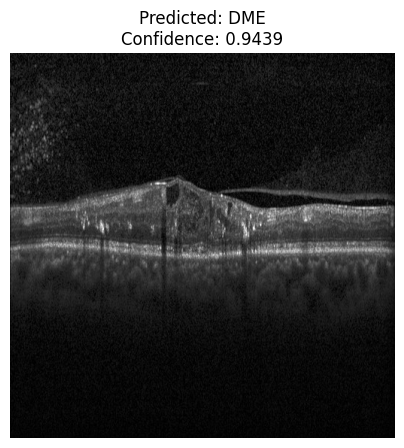

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : DME
Confidence     : 0.9439

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Anti-VEGF intravitreal merupakan terapi utama pada DME, khususnya untuk perbaikan fungsi penglihatan.
2. Kortikosteroid intravitreal dapat dipertimbangkan pada DME persisten atau kurang respons terhadap anti-VEGF, dengan pemantauan risiko peningkatan tekanan intraokular dan katarak.
3. Laser fotokoagulasi lebih sering berperan sebagai terapi adjuvan, bukan lini pertama.
4. Vitrektomi dipertimbangkan pada kasus dengan indikasi bedah tertentu, seperti adanya komponen traksi vitreomakular.
5. Kontrol faktor sistemik (glukosa darah, tekanan darah, dan lipid) merupakan bagian penting dari penatalaksanaan komprehensif.

⚠️ Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


('DME', 0.9439185261726379)

In [ ]:
img_path = "/content/dataset_split/test/DME/DME-3064922-198.jpeg"
predict_top1_with_therapy(modelload, img_path, class_names)

Saving DME-3064922-198.jpeg to DME-3064922-198.jpeg


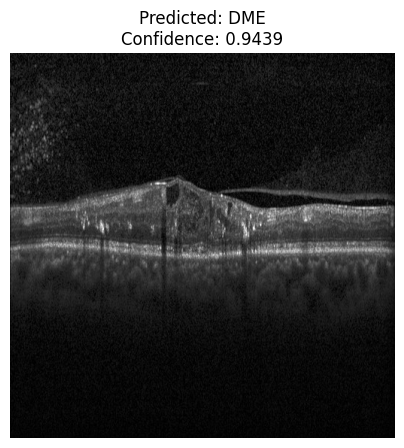

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : DME
Confidence     : 0.9439

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Anti-VEGF intravitreal merupakan terapi utama pada DME, khususnya untuk perbaikan fungsi penglihatan.
2. Kortikosteroid intravitreal dapat dipertimbangkan pada DME persisten atau kurang respons terhadap anti-VEGF, dengan pemantauan risiko peningkatan tekanan intraokular dan katarak.
3. Laser fotokoagulasi lebih sering berperan sebagai terapi adjuvan, bukan lini pertama.
4. Vitrektomi dipertimbangkan pada kasus dengan indikasi bedah tertentu, seperti adanya komponen traksi vitreomakular.
5. Kontrol faktor sistemik (glukosa darah, tekanan darah, dan lipid) merupakan bagian penting dari penatalaksanaan komprehensif.

⚠️ Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


In [ ]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

pred_label, conf = predict_top1_with_therapy(modelload, img_path, class_names)


##Versi DATA split 7 : 1,5 : 1,5

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMG_SIZE = 224

In [ ]:
RAW_DIR = Path("/content/drive/MyDrive/dataset_TA/extra")  # folder asli
SPLIT_DIR = Path("/content/dataset_split") # output split
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

class_names = sorted([d.name for d in RAW_DIR.iterdir() if d.is_dir()])
print("Classes:", class_names)

# (opsional) standarisasi max 6000/kelas
MAX_PER_CLASS = 6000

# rasio 7:1,5:1,5
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15

def list_images(class_dir):
    files = [p for p in class_dir.rglob("*")
             if p.is_file() and p.suffix.lower() in IMG_EXTS]
    return files

def prepare_dirs():
    for split in ["train","val","test"]:
        for c in class_names:
            (SPLIT_DIR/split/c).mkdir(parents=True, exist_ok=True)

prepare_dirs()

for c in class_names:
    files = list_images(RAW_DIR/c)
    random.shuffle(files)

    if MAX_PER_CLASS is not None:
        files = files[:MAX_PER_CLASS]  # memastikan 6000/kelas

    n = len(files)
    n_train = int(TRAIN_RATIO * n)
    n_val   = int(VAL_RATIO * n)
    # sisanya test

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    def copy_files(file_list, split_name):
        for p in file_list:
            dst = SPLIT_DIR/split_name/c/p.name
            shutil.copy2(p, dst)

    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print(c, "-> Train:", len(train_files),' |val:', len(val_files)," |Test:", len(test_files))

print("Done split into:", SPLIT_DIR)

Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
CNV -> Train: 4200  |val: 900  |Test: 900
DME -> Train: 4200  |val: 900  |Test: 900
DRUSEN -> Train: 4200  |val: 900  |Test: 900
NORMAL -> Train: 4200  |val: 900  |Test: 900
Done split into: /content/dataset_split


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.10),
], name="augment")

In [ ]:
def load_ds(path, training=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        image_size=(IMG_SIZE, IMG_SIZE),#resize
        batch_size=BATCH_SIZE,
        shuffle=training
    )

    class_names = ds.class_names  #  ambil DI SINI

    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y), #normalisasi
                num_parallel_calls=AUTOTUNE)

    #augment training
    if training:
        ds = ds.map(lambda x,y: (data_augment(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    if not training:
        ds = ds.cache()

    ds = ds.prefetch(AUTOTUNE)
    return ds, class_names


In [ ]:
train_ds, class_names = load_ds(SPLIT_DIR/"train", training=True)
val_ds, _ = load_ds(SPLIT_DIR/"val", training=False)
test_ds, _ = load_ds(SPLIT_DIR/"test", training=False)

print("class_names:", class_names)

Found 16800 files belonging to 4 classes.
Found 3600 files belonging to 4 classes.
Found 3600 files belonging to 4 classes.
class_names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.proj = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)

def build_vit_small(
    input_shape=(224,224,3),
    num_classes=4,
    patch_size=16,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    dropout=0.1
):
    inputs = keras.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) ** 2

    x = PatchEncoder(num_patches, embed_dim)(patches)
    x = layers.Dropout(dropout)(x)

    for _ in range(depth):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout
        )(x1, x1)
        x2 = layers.Add()([x, attn])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(embed_dim*mlp_ratio, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x3 = layers.Dense(embed_dim)(x3)
        x = layers.Add()([x2, x3])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="vit_small")


model = build_vit_small(num_classes=len(class_names))
model.summary()

Model: "vit_small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, None, 384) │    370,560 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 384) │          0 │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 384) │        768 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 384) │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 384) │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │    591,360 │ layer_normalizat… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None,      │          0 │ dense_1[0][0]     │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 384) │    590,208 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 384) │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 384) │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 384) │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 384) │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │    591,360 │ layer_normalizat… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None,      │          0 │ dense_3[0][0]   

 Total params: 21,666,436 (82.65 MB)

 Trainable params: 21,666,436 (82.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
NUM_CLASSES = len(class_names)

def to_one_hot(images, labels):
    return images, tf.one_hot(labels, NUM_CLASSES)

train_ds_oh = train_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_oh   = val_ds.map(to_one_hot,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_oh  = test_ds.map(to_one_hot,  num_parallel_calls=tf.data.AUTOTUNE)  # untuk evaluasi nanti

train_ds_oh = train_ds_oh.prefetch(tf.data.AUTOTUNE)
val_ds_oh   = val_ds_oh.prefetch(tf.data.AUTOTUNE)
test_ds_oh  = test_ds_oh.prefetch(tf.data.AUTOTUNE)


In [ ]:
EPOCHS = 50

steps_per_epoch = tf.data.experimental.cardinality(train_ds_oh).numpy()
if steps_per_epoch == tf.data.experimental.INFINITE_CARDINALITY:
    raise ValueError("Dataset cardinality infinite. Pastikan train_ds tidak di-repeat tanpa batas.")
if steps_per_epoch == tf.data.experimental.UNKNOWN_CARDINALITY:
    raise ValueError("Dataset cardinality unknown. Coba hilangkan cache/transform yang bikin unknown, atau set steps_per_epoch manual.")

total_steps = steps_per_epoch * EPOCHS

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps,
    alpha=1e-2
)

optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [ ]:
class SaveAtEpochs(keras.callbacks.Callback):
    def __init__(self, save_epochs, save_dir="epoch_checkpoints_V71515"):
        super().__init__()
        self.save_epochs = set(save_epochs)   # {20, 40, 50}
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        epoch_human = epoch + 1
        if epoch_human in self.save_epochs:
            path = os.path.join(
                self.save_dir,
                f"vit_epoch_{epoch_human:02d}.keras"
            )
            self.model.save(path)
            print(f"\n Saved checkpoint di epoch {epoch_human} -> {path}")


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=50,
        restore_best_weights=False,
        verbose=1
    ),
    SaveAtEpochs(
        save_epochs=[20, 40, 50],
        save_dir="epoch_checkpoints_V71515"
    )
]

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

history = model.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.2526 - loss: 1.8742 - val_accuracy: 0.3092 - val_loss: 1.3900
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 262s 991ms/step - accuracy: 0.2661 - loss: 1.4280 - val_accuracy: 0.3350 - val_loss: 1.3679
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 260s 981ms/step - accuracy: 0.3164 - loss: 1.3823 - val_accuracy: 0.3975 - val_loss: 1.3054
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 257s 969ms/step - accuracy: 0.3727 - loss: 1.3184 - val_accuracy: 0.4192 - val_loss: 1.2629
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 256s 970ms/step - accuracy: 0.4438 - loss: 1.2505 - val_accuracy: 0.4878 - val_loss: 1.2064
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 256s 968ms/step - accuracy: 0.5314 - loss: 1.1333 - val_accuracy: 0.5853 - val_loss: 1.0790
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.5952 - loss: 1.0504 - val_accuracy: 0.6239 - val_loss: 1.0221
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 266s 984ms/step - accuracy: 0.6447 - loss:

In [ ]:
model.save("final_vit_model_16p_71515.keras")

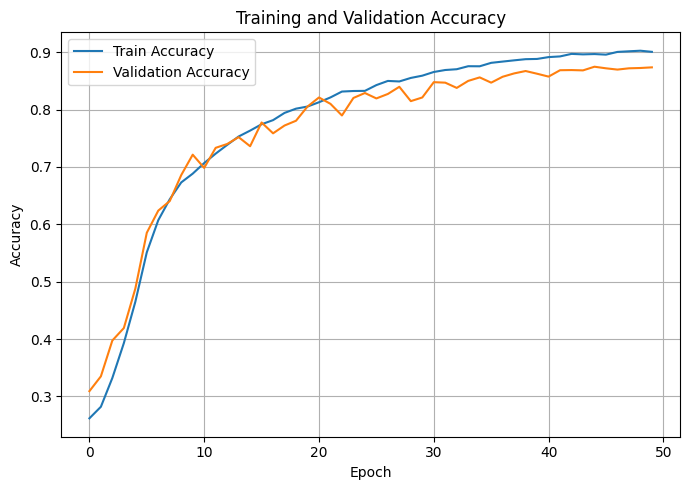

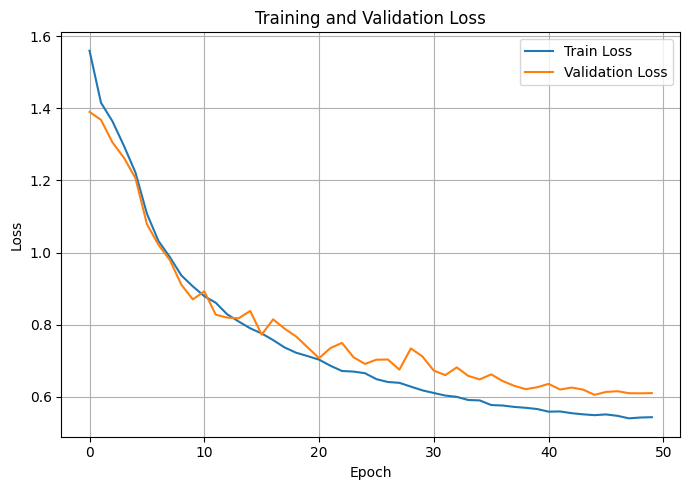

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(7,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf

def collect_preds(ds, model):
    y_true_list = []
    y_prob_list = []

    for x_batch, y_batch in ds:
        probs = model.predict(x_batch, verbose=0)
        y_prob_list.append(probs)

        yb = y_batch.numpy()
        # Jika y_batch one-hot -> ambil argmax, jika integer -> langsung
        if len(yb.shape) == 2:
            y_true_list.append(np.argmax(yb, axis=1))
        else:
            y_true_list.append(yb)

    y_true = np.concatenate(y_true_list, axis=0)
    y_prob = np.concatenate(y_prob_list, axis=0)
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob

ds_for_eval = test_ds
#ds_for_eval = test_ds_oh

y_true, y_pred, y_prob = collect_preds(ds_for_eval, model)
num_classes = len(class_names)

print("Total test samples:", len(y_true))
print("Num classes:", num_classes)


Total test samples: 3600
Num classes: 4


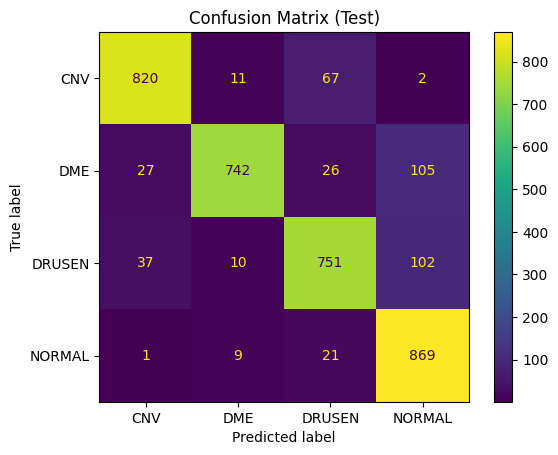


Classification Report:
              precision    recall  f1-score   support

         CNV     0.9266    0.9111    0.9188       900
         DME     0.9611    0.8244    0.8876       900
      DRUSEN     0.8682    0.8344    0.8510       900
      NORMAL     0.8061    0.9656    0.8787       900

    accuracy                         0.8839      3600
   macro avg     0.8905    0.8839    0.8840      3600
weighted avg     0.8905    0.8839    0.8840      3600



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


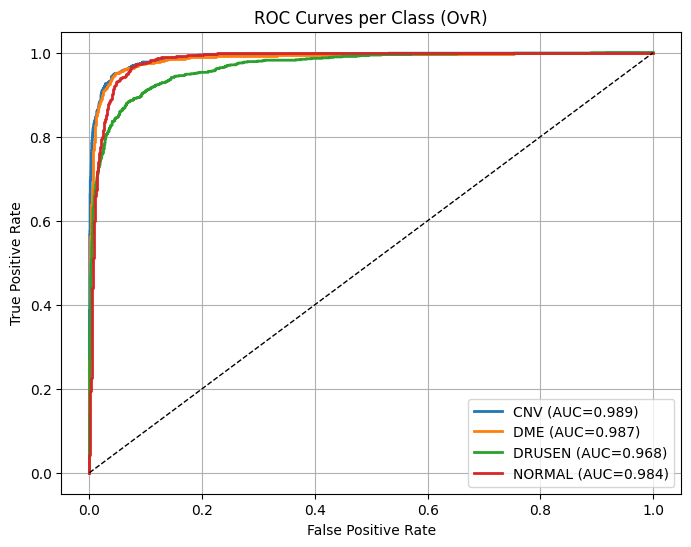


ROC–AUC per kelas:
- CNV: 0.9895
- DME: 0.9870
- DRUSEN: 0.9677
- NORMAL: 0.9839
Macro ROC–AUC: 0.9820274691358025


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nROC–AUC per kelas:")
for i in range(num_classes):
    print(f"- {class_names[i]}: {roc_auc[i]:.4f}")
print("Macro ROC–AUC:", float(np.mean(list(roc_auc.values()))))


In [ ]:
def sensitivity_specificity(cm, class_names):
    results = []
    total = cm.sum()
    num_classes = cm.shape[0]

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        results.append({
            "class": class_names[i],
            "Sensitivity": sensitivity,
            "Specificity": specificity
        })

    return results


In [ ]:
results = sensitivity_specificity(cm, class_names)

print("\nSensitivity & Specificity per kelas:")
for r in results:
    print(
        f"- {r['class']:10s} | "
        f"Sensitivity: {r['Sensitivity']:.4f} | "
        f"Specificity: {r['Specificity']:.4f}"
    )

# Macro average
macro_sens = np.mean([r["Sensitivity"] for r in results])
macro_spec = np.mean([r["Specificity"] for r in results])

print("\nMacro Average:")
print(f"Sensitivity (macro): {macro_sens:.4f}")
print(f"Specificity (macro): {macro_spec:.4f}")



Sensitivity & Specificity per kelas:
- CNV        | Sensitivity: 0.9111 | Specificity: 0.9759
- DME        | Sensitivity: 0.8244 | Specificity: 0.9889
- DRUSEN     | Sensitivity: 0.8344 | Specificity: 0.9578
- NORMAL     | Sensitivity: 0.9656 | Specificity: 0.9226

Macro Average:
Sensitivity (macro): 0.8839
Specificity (macro): 0.9613


inferensi

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.proj = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim": self.embed_dim
        })
        return config


In [ ]:
modelload = keras.models.load_model(
    "/content/final_vit_model_16p_71515.keras",
    custom_objects={
        "Patches": Patches,
        "PatchEncoder": PatchEncoder
    },
    compile=False
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
import os

SPLIT_DIR = "/content/dataset_split"  # ganti sesuai path split kamu
class_names = sorted(os.listdir(f"{SPLIT_DIR}/train"))
print("class_names:", class_names)

class_names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [ ]:
import numpy as np
from PIL import Image

IMG_SIZE = 224

def predict_image(model, img_path, class_names, img_size=224):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((img_size, img_size))
    x = np.array(img).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)  # (1,224,224,3)

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]

    return pred_label, probs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = 224

# =========================
# Mapping rekomendasi terapi
# =========================
THERAPY_RECOMMENDATION = {
    "cnv": [
        "Injeksi intravitreal anti-VEGF sebagai terapi utama pada CNV aktif, terutama pada CNV terkait AMD neovaskular maupun CNV miopia.",
        "Monitoring respon terapi secara berkala melalui pemeriksaan klinis dan pencitraan, karena CNV sering memerlukan terapi berulang atau penyesuaian protokol.",
        "Pemantauan efek samping terapi anti-VEGF diperlukan karena adanya potensi risiko okular tertentu."
    ],
    "dme": [
        "Anti-VEGF intravitreal merupakan terapi utama pada DME, khususnya untuk perbaikan fungsi penglihatan.",
        "Kortikosteroid intravitreal dapat dipertimbangkan pada DME persisten atau kurang respons terhadap anti-VEGF, dengan pemantauan risiko peningkatan tekanan intraokular dan katarak.",
        "Laser fotokoagulasi lebih sering berperan sebagai terapi adjuvan, bukan lini pertama.",
        "Vitrektomi dipertimbangkan pada kasus dengan indikasi bedah tertentu, seperti adanya komponen traksi vitreomakular.",
        "Kontrol faktor sistemik (glukosa darah, tekanan darah, dan lipid) merupakan bagian penting dari penatalaksanaan komprehensif."
    ],
    "drusen": [
        "Suplemen formula AREDS/AREDS2 direkomendasikan pada kondisi AMD tertentu, khususnya intermediate AMD atau drusen besar, untuk memperlambat progresi penyakit.",
        "Modifikasi gaya hidup dan pemantauan berkala diperlukan untuk mendeteksi progresi menuju AMD lanjut.",
        "Apabila berkembang menjadi AMD neovaskular dengan CNV, pendekatan terapi beralih ke anti-VEGF."
    ]
}


def predict_top1_with_therapy(model, img_path, class_names, img_size=224):
    # --- Preprocess ---
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((img_size, img_size))
    x = np.array(img_resized).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)

    # --- Predict ---
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    confidence = float(probs[pred_idx])

    # --- Tampilkan gambar ---
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label.upper()}\nConfidence: {confidence:.4f}")
    plt.show()

    # --- Rekomendasi terapi ---
    label_key = pred_label.lower()
    recommendations = THERAPY_RECOMMENDATION.get(label_key, [])

    print("=== HASIL INFERENSI MODEL ===")
    print(f"Kelas Prediksi : {pred_label.upper()}")
    print(f"Confidence     : {confidence:.4f}\n")

    print("=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    print("\n Note:")
    print("Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.")

    return pred_label, confidence



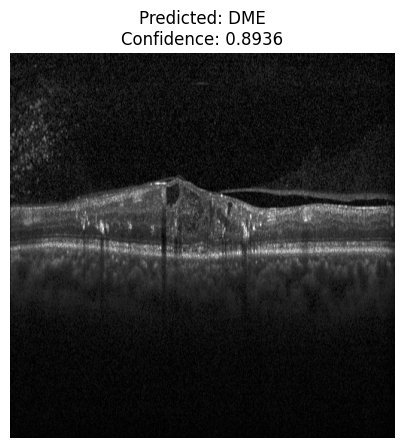

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : DME
Confidence     : 0.8936

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Anti-VEGF intravitreal merupakan terapi utama pada DME, khususnya untuk perbaikan fungsi penglihatan.
2. Kortikosteroid intravitreal dapat dipertimbangkan pada DME persisten atau kurang respons terhadap anti-VEGF, dengan pemantauan risiko peningkatan tekanan intraokular dan katarak.
3. Laser fotokoagulasi lebih sering berperan sebagai terapi adjuvan, bukan lini pertama.
4. Vitrektomi dipertimbangkan pada kasus dengan indikasi bedah tertentu, seperti adanya komponen traksi vitreomakular.
5. Kontrol faktor sistemik (glukosa darah, tekanan darah, dan lipid) merupakan bagian penting dari penatalaksanaan komprehensif.

 Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


('DME', 0.8935539722442627)

In [ ]:
img_path = "/content/dataset_split/test/DME/DME-3064922-198.jpeg"
predict_top1_with_therapy(modelload, img_path, class_names)

Saving CNV-7852568-133.jpeg to CNV-7852568-133.jpeg


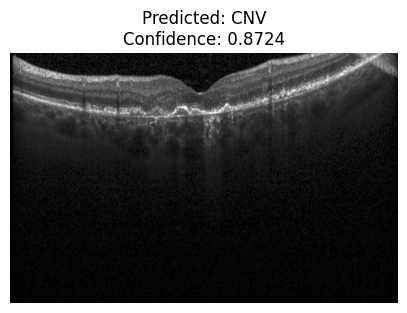

=== HASIL INFERENSI MODEL ===
Kelas Prediksi : CNV
Confidence     : 0.8724

=== REKOMENDASI TERAPI (BERDASARKAN KELAS) ===
1. Injeksi intravitreal anti-VEGF sebagai terapi utama pada CNV aktif, terutama pada CNV terkait AMD neovaskular maupun CNV miopia.
2. Monitoring respon terapi secara berkala melalui pemeriksaan klinis dan pencitraan, karena CNV sering memerlukan terapi berulang atau penyesuaian protokol.
3. Pemantauan efek samping terapi anti-VEGF diperlukan karena adanya potensi risiko okular tertentu.

 Note:
Hasil ini merupakan dukungan keputusan berbasis model AI dan tidak menggantikan penilaian klinis dokter mata.


In [ ]:
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

pred_label, conf = predict_top1_with_therapy(modelload, img_path, class_names)

##### weight(DUMMY)

In [ ]:
# SIMPAN WEIGHT
model.save_weights("vit_small.weights.h5")

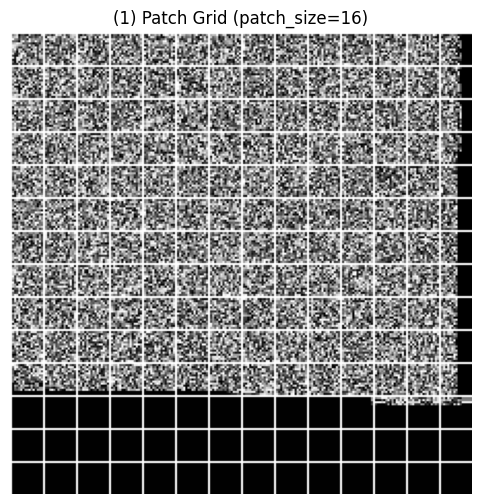

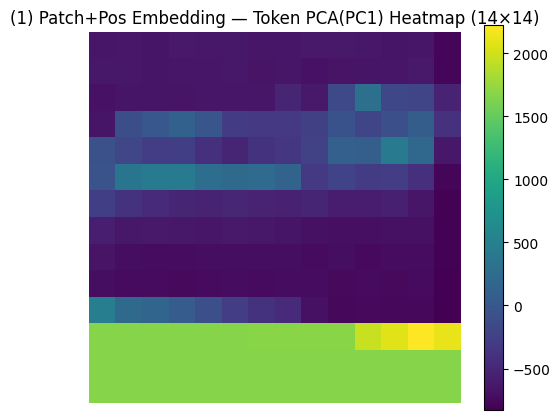

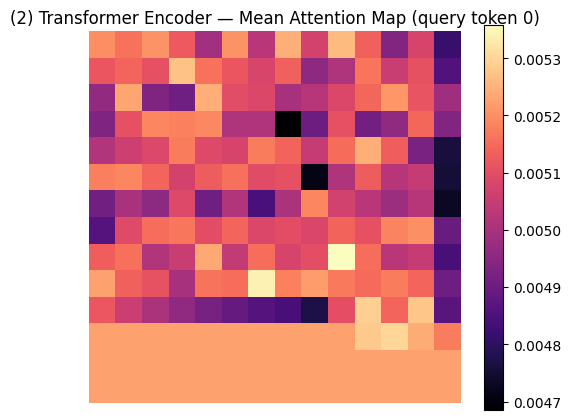

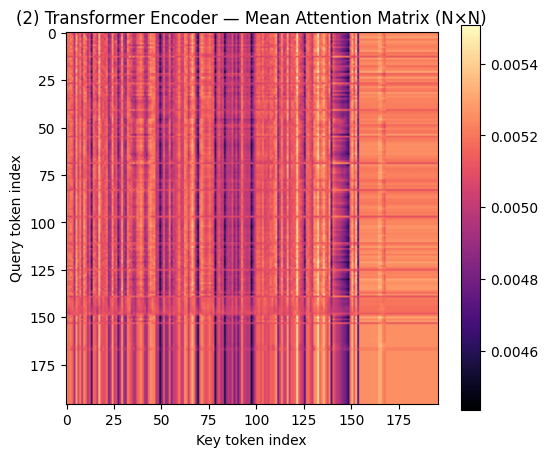

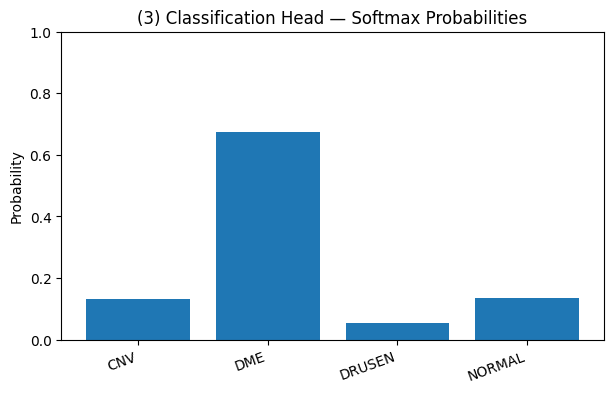

Predicted: DME | prob = 0.6752016544342041


'\n\n\n\n\n\n\n'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) Utilities
# =========================
def load_image_tensor(path, image_size=(224,224), grayscale=False):
    img_bytes = tf.io.read_file(path)
    if path.lower().endswith(".png"):
        img = tf.io.decode_png(img_bytes, channels=1 if grayscale else 3)
    else:
        img = tf.io.decode_jpeg(img_bytes, channels=1 if grayscale else 3)

    img = tf.image.resize(img, image_size)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img

def pca_1d_to_2d(X):
    """
    X: (N, D) numpy
    returns: (N,) scores on PC1 (for heatmap), and (N,2) if you want scatter.
    """
    Xc = X - X.mean(axis=0, keepdims=True)
    # SVD PCA
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    pc1 = Xc @ Vt[0].T
    pc2 = Xc @ Vt[1].T
    return pc1, np.stack([pc1, pc2], axis=1)

def show_patch_grid(img, patch_size=16, title="Patch Grid (14×14)"):
    """
    img: (224,224,C) float32 [0,1]
    """
    img_np = img.numpy()
    H, W = img_np.shape[:2]
    gh, gw = H // patch_size, W // patch_size

    # create a visual grid by drawing patch borders
    vis = (img_np.copy() * 255).astype(np.uint8)
    for r in range(gh):
        y = r * patch_size
        vis[y:y+1, :, :] = 255
    for c in range(gw):
        x = c * patch_size
        vis[:, x:x+1, :] = 255

    plt.figure(figsize=(6,6))
    if vis.shape[-1] == 1:
        plt.imshow(vis.squeeze(), cmap="gray")
    else:
        plt.imshow(vis)
    plt.title(title)
    plt.axis("off")
    plt.show()

# =========================
# 1) Rebuild a "debug" ViT-Small that can return:
#    - patches
#    - tokens after PatchEncoder (patch+pos)
#    - attention maps (from a chosen block)
#    - final probs
# =========================

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        b = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        d = patches.shape[-1]
        return tf.reshape(patches, [b, -1, d])

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.proj = tf.keras.layers.Dense(embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(num_patches, embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1])
        return self.proj(patches) + self.pos_emb(positions)


def build_vit_small_debug(
    input_shape=(224,224,3),
    num_classes=4,
    patch_size=16,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    dropout=0.1,
    attention_block_index=None,   # which block to return attention from (0..depth-1)
):
    if attention_block_index is None:
        attention_block_index = depth - 1

    inputs = tf.keras.Input(shape=input_shape)
    patches = Patches(patch_size, name="patches")(inputs)

    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    tokens = PatchEncoder(num_patches, embed_dim, name="patch_encoder")(patches)
    tokens = tf.keras.layers.Dropout(dropout)(tokens)

    attn_scores_out = None
    x = tokens

    for b in range(depth):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{b}")(x)

        mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout,
            name=f"mha_{b}"
        )

        # IMPORTANT: return_attention_scores=True to get attention weights
        attn_out, attn_scores = mha(x1, x1, return_attention_scores=True)

        x2 = tf.keras.layers.Add(name=f"add_attn_{b}")([x, attn_out])

        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{b}")(x2)
        x3 = tf.keras.layers.Dense(embed_dim*mlp_ratio, activation=tf.nn.gelu, name=f"mlp_fc1_{b}")(x3)
        x3 = tf.keras.layers.Dropout(dropout, name=f"mlp_drop_{b}")(x3)
        x3 = tf.keras.layers.Dense(embed_dim, name=f"mlp_fc2_{b}")(x3)
        x = tf.keras.layers.Add(name=f"add_mlp_{b}")([x2, x3])

        if b == attention_block_index:
            attn_scores_out = attn_scores  # (B, heads, N, N)

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="final_ln")(x)
    pooled = tf.keras.layers.GlobalAveragePooling1D(name="gap")(x)
    pooled = tf.keras.layers.Dropout(dropout, name="head_drop")(pooled)
    probs = tf.keras.layers.Dense(num_classes, activation="softmax", name="head_softmax")(pooled)

    # Model outputs multiple things for visualization
    debug_model = tf.keras.Model(
        inputs=inputs,
        outputs=[patches, tokens, attn_scores_out, probs],
        name="vit_small"
    )
    return debug_model

# =========================
# 2) Visualization runner
# =========================
def visualize_vit_stages(
    debug_model,
    img_tensor,          # (224,224,C) float32 [0,1]
    class_names=None,
    patch_size=16
):
    # add batch dim
    x = tf.expand_dims(img_tensor, axis=0)

    patches, tokens, attn_scores, probs = debug_model(x, training=False)

    patches = patches.numpy()[0]      # (N, Dpatch)
    tokens = tokens.numpy()[0]        # (N, E)
    attn_scores = attn_scores.numpy()[0]  # (heads, N, N)
    probs = probs.numpy()[0]          # (num_classes,)

    # -------- (1) Patch grid visualization --------
    show_patch_grid(img_tensor, patch_size=patch_size, title="(1) Patch Grid (patch_size=16)")

    # Heatmap from token embeddings using PCA(PC1) arranged into 14x14
    N = tokens.shape[0]
    grid = int(np.sqrt(N))
    pc1, pc12 = pca_1d_to_2d(tokens)  # pc1: (N,)
    pc1_map = pc1.reshape(grid, grid)

    plt.figure(figsize=(6,5))
    plt.imshow(pc1_map, cmap="viridis")
    plt.colorbar()
    plt.title("(1) Patch+Pos Embedding — Heatmap (14×14)")
    plt.axis("off")
    plt.show()

    # -------- (2) Transformer Encoder: Attention map --------
    # Average attention over heads
    attn_mean = attn_scores.mean(axis=0)  # (N, N)

    # Choose a query token index to visualize (0 by default)
    q = 0
    attn_q = attn_mean[q].reshape(grid, grid)

    plt.figure(figsize=(6,5))
    plt.imshow(attn_q, cmap="magma")
    plt.colorbar()
    plt.title(f"(2) Transformer Encoder — Mean Attention Map (query token {q})")
    plt.axis("off")
    plt.show()

    # Optional: show full attention matrix
    plt.figure(figsize=(6,5))
    plt.imshow(attn_mean, cmap="magma")
    plt.colorbar()
    plt.title("(2) Transformer Encoder — Mean Attention Matrix (N×N)")
    plt.xlabel("Key token index")
    plt.ylabel("Query token index")
    plt.show()

    # -------- (3) Classification Head: Probabilities --------
    plt.figure(figsize=(7,4))
    labels = class_names if class_names is not None else [f"class_{i}" for i in range(len(probs))]
    plt.bar(labels, probs)
    plt.title("(3) Classification Head — Softmax Probabilities")
    plt.ylabel("Probability")
    plt.xticks(rotation=20, ha="right")
    plt.ylim(0, 1)
    plt.show()

    # print top prediction
    top_idx = int(np.argmax(probs))
    print("Predicted:", labels[top_idx], "| prob =", float(probs[top_idx]))

# =========================
# 3) HOW TO USE
# =========================

# 1) Build debug model with SAME config as your ViT-Small
debug_model = build_vit_small_debug(
    input_shape=(224,224,3),
    num_classes=len(class_names),
    patch_size=16,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    dropout=0.1,
    attention_block_index=11  # last block
)

# 2) IMPORTANT: load trained weights from your original model
# If you trained a model named "vit_small", load its weights file:
debug_model.load_weights("/content/vit_small.weights.h5")


# 3) Load 1 sample image
img = load_image_tensor("/content/dataset_split/test/DME/DME-2817912-12.jpeg", grayscale=False)  # or True if 1 channel
# Ensure channel matches debug_model input_shape


# 4) Visualize stages
visualize_vit_stages(debug_model, img, class_names=class_names, patch_size=16)
"""






"""
